In [ ]:
# 1- Scrap the diabetes Data (Q_A)
# 2- get the data in the desired format of gpt3.5-turbo + save it in jsonl
# 3- fine tune the model
# 3- use the finetuned model

Before finetuning,you should have a look on the pricing: fine tuning costs: https://openai.com/blog/gpt-3-5-turbo-fine-tuning-and-api-updates

Also the Fine-tuning is currently available for the following models:
`
gpt-3.5-turbo-0613 (recommended)
babbage-002
davinci-002
`

In [ ]:
!pip install PyPDF2 tiktoken python-dotenv langchain openai chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 86.4 MB/s 

##Scraping the Data

In [ ]:
!pip install beautifulsoup4 requests jsonlines

In [ ]:
import requests
from bs4 import BeautifulSoup
import jsonlines

# URL of the page that contains questions & responses about diabetes
url = "https://diabetesaction.org/questions-general-information"

response = requests.get(url)

if response.status_code == 200:
    # Parse the HTML content of the page using BeautifulSoup
    soup = BeautifulSoup(response.text, "html.parser")

    qa_pairs = []
    current_qa = None

    for element in soup.find_all(["p", "h1"]):
        text = element.get_text().strip()
        if text.startswith("Q:"):
            if current_qa:
                qa_pairs.append(current_qa)


            current_qa = {"Question": text[2:].split('A:')[0].strip(), "Answer": text[2:].split('A:')[1].strip()}

    if current_qa:
        qa_pairs.append(current_qa)


else:
    print("Failed to retrieve the web page. Status code:", response.status_code)


In [ ]:
qa_pairs[5]

{'Question': 'I read that people with diabetes should not use heating pads. Why not?',
 'Answer': 'This recommendation is more of a caution for those who have neuropathy and may not feel if the pad gets too hot and could be burned as a result.'}

In [ ]:
len(qa_pairs)

54

##Processing & transforming the data

We'll fine tune gpt3.5-turbo, so the dataset format should be training examples in this format.
https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset

`
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}
`



In [ ]:
full_data=[{"messages": [{"role": "system", "content": "You are a helpful diabetes doctor."}
              , {"role": "user", "content": ""},
              {"role": "assistant", "content": ""}]} for i in range(len(qa_pairs))]

In [ ]:
for i in range(len(qa_pairs)):

    full_data[i]['messages'][1]['content']=qa_pairs[i]['Question']
    full_data[i]['messages'][2]['content']=qa_pairs[i]['Answer']


In [ ]:
full_data[5]

{'messages': [{'role': 'system',
   'content': 'You are a helpful diabetes doctor.'},
  {'role': 'user',
   'content': 'I read that people with diabetes should not use heating pads. Why not?'},
  {'role': 'assistant',
   'content': 'This recommendation is more of a caution for those who have neuropathy and may not feel if the pad gets too hot and could be burned as a result.'}]}

In [ ]:
#save the data in jsonl format to be training file
with jsonlines.open("diabetes_qa.jsonl", mode="w") as writer:
        for data in full_data:
            writer.write(data)

##FineTuning gpt3.5-turbo part

In [ ]:
import openai
import ast
import os
from dotenv import load_dotenv
from langchain import PromptTemplate, LLMChain
from langchain.chains import SequentialChain
from langchain.chat_models import ChatOpenAI
from langchain.chat_models import AzureChatOpenAI

In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")

openai.File.create(
  file=open("diabetes_qa.jsonl", "rb"),
  purpose='fine-tune'
)

<File file id=file-W3a7sQQm06EmFArN5AimVQhH at 0x781079a27e70> JSON: {
  "object": "file",
  "id": "file-W3a7sQQm06EmFArN5AimVQhH",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 3959,
  "created_at": 1693844681,
  "status": "uploaded",
  "status_details": null
}

In [ ]:
openai.FineTuningJob.create(training_file="file-W3a7sQQm06EmFArN5AimVQhH", model="gpt-3.5-turbo")
#you should notice that   "finished_at": null

<FineTuningJob fine_tuning.job id=ftjob-c1QcWCIhfHS7kkpDpLGC55EB at 0x781079859b70> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-c1QcWCIhfHS7kkpDpLGC55EB",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693844693,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-xMtkzKyhUcNQT5Zpep3rAnUr",
  "result_files": [],
  "status": "created",
  "validation_file": null,
  "training_file": "file-W3a7sQQm06EmFArN5AimVQhH",
  "hyperparameters": {
    "n_epochs": 8
  },
  "trained_tokens": null
}

In [ ]:
from time import sleep

while True:
    res = openai.FineTuningJob.retrieve('ftjob-c1QcWCIhfHS7kkpDpLGC55EB')
    if res["finished_at"] != None:
        break
    else:
        print(".", end="")
        sleep(100)

.....

In [ ]:
res
#the status should be succeeded after fine tuning,   "finished_at": 1693845135

<FineTuningJob fine_tuning.job id=ftjob-c1QcWCIhfHS7kkpDpLGC55EB at 0x7810865b6160> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-c1QcWCIhfHS7kkpDpLGC55EB",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693844693,
  "finished_at": 1693845135,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:talentguide::7v6mmOYg",
  "organization_id": "org-xMtkzKyhUcNQT5Zpep3rAnUr",
  "result_files": [
    "file-NQqefUOJNH28tyGp11K2hF9U"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-W3a7sQQm06EmFArN5AimVQhH",
  "hyperparameters": {
    "n_epochs": 8
  },
  "trained_tokens": 6016
}

after fine tuning successfully you should reveive this email from openAI so you can use it in the playground.


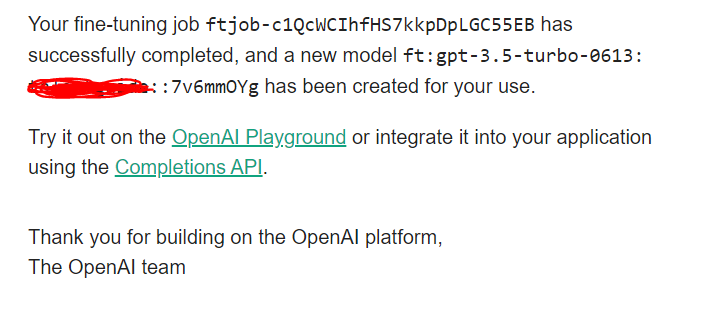

In [ ]:
finetuned_model = res["fine_tuned_model"]
finetuned_model

In [ ]:
#you can simply use the model with chatCompletition openAi
completion = openai.ChatCompletion.create(
  model=finetuned_model,
  messages=[
    {"role": "user", "content": "Hello!"}
  ]
)
response= completion.choices[0].message)

In [ ]:
#or you can use the model with langchain & ChatOpenAI and history ...
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferWindowMemory

llm = ChatOpenAI(
    temperature=0.5,
    model_name=finetuned_model
)

memory = ConversationBufferWindowMemory(
    memory_key="chat_history",
    k=5,
    return_messages=True,
    output_key="output"
)

In [ ]:
#once the model works fine, you can deploy it with front end or simply use the Playground of openAI.

In the playground, you can choose your fine tuned model and use it easily.

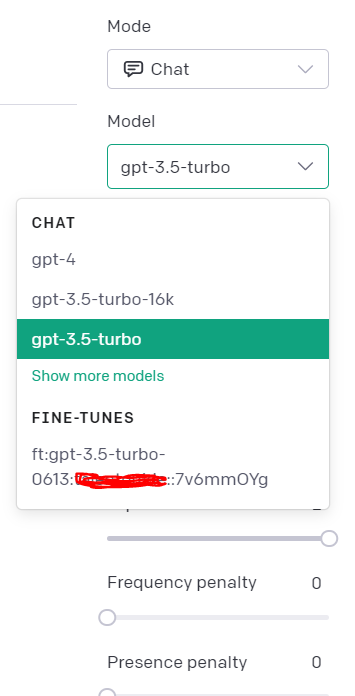